# Bike Sharing Demand - Data Analysis and Prediction

### Overview  <br>
Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. 

### Objective <br>
Combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

### Data Description <br>

Hourly rental data spanning two years are provided. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Data Fields <br>
datetime - hourly date + timestamp  <br>
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter <br>
holiday - whether the day is considered a holiday <br>
workingday - whether the day is neither a weekend nor holiday <br>
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
temp - temperature in Celsius <br>
atemp - "feels like" temperature in Celsius <br>
humidity - relative humidity <br>
windspeed - wind speed <br>
casual - number of non-registered user rentals initiated <br>
registered - number of registered user rentals initiated <br>
count - number of total rentals <br>

**Submissions are evaluated on the basis of Root Mean Squared Logarithmic Error (RMSLE)**

In [56]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import scipy.stats as stats
from scipy import stats
from scipy.stats import pointbiserialr, spearmanr, skew, pearsonr

In [57]:
# Importing the datas
train_data = pd.read_csv('./Data/train.csv')
test_data = pd.read_csv('./Data/test.csv')

In [58]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [59]:
# Check for duplicates
train_data.drop_duplicates(subset=None, keep='first', inplace=True);

In [60]:
train_data['datetime'] = pd.to_datetime(train_data['datetime'])

In [61]:
# Mapping Season
train_data['season'] = train_data.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })

In [62]:
# Mapping Weather
train_data['weather'] = train_data.weather.map({1: "Clear", 2: "Cloudy", 3: "Light Rain", 4: "Heavy Rain"})

In [63]:
# Extract year, month, day, hour from the datetime data
train_data['year'] = train_data['datetime'].dt.year
train_data['month'] = train_data['datetime'].dt.month
train_data['day'] = train_data['datetime'].dt.day
train_data['hour'] = train_data['datetime'].dt.hour
train_data['day_of_week'] = train_data['datetime'].dt.dayofweek

In [64]:
# Categorical variables
cat_var = ['season', 'holiday', 'workingday', 'weather','year', 'month', 'day', 'hour', 'day_of_week']

In [65]:
# Defining a function for all the data transformation
def data_transformation(dataframe):
    dataframe.drop_duplicates(subset=None, keep='first', inplace=True);
    dataframe['datetime'] = pd.to_datetime(dataframe['datetime'])
    dataframe['season'] = dataframe.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
    dataframe['weather'] = dataframe.weather.map({1: "Clear", 2: "Cloudy", 3: "Light Rain", 4: "Heavy Rain"})
    dataframe['year'] = dataframe['datetime'].dt.year
    dataframe['month'] = dataframe['datetime'].dt.month
    dataframe['day'] = dataframe['datetime'].dt.day
    dataframe['hour'] = dataframe['datetime'].dt.hour
    dataframe['day_of_week'] = dataframe['datetime'].dt.dayofweek
    dataframe.drop(remove_feature, axis=1)

In [66]:
# Categorical variables
cat_var = ['season', 'holiday', 'workingday', 'weather','year', 'month', 'day', 'hour', 'day_of_week']
#Numerical variables
num_var = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']


No missing data

In [67]:
corr_matrix = train_data.corr()

In [68]:
# Defining spearman correlation for all variables
def corr_spr(dataframe):
    mat = []
    for i in dataframe.columns:
        for j in dataframe.columns:
            mat.append(spearmanr(dataframe[i], dataframe[j])[0])
    return mat

In [69]:
# list of spearman correlation values
corr_spr_list = corr_spr(train_data.iloc[:,1:])
#converting spearman correlation values into dataframe
corr_spr_mat = pd.DataFrame(np.array(corr_spr_list).reshape(16,16), columns = train_data.iloc[:,1:].columns, index=train_data.iloc[:,1:].columns)

In [70]:
# Correlation (pearson) with respect to target variable (count)
corr_matrix["count"].sort_values(ascending=False)

count          1.000000
registered     0.970948
casual         0.690414
hour           0.400601
temp           0.394454
atemp          0.389784
year           0.260403
month          0.166862
windspeed      0.101369
day            0.019826
workingday     0.011594
day_of_week   -0.002283
holiday       -0.005393
humidity      -0.317371
Name: count, dtype: float64

Most important are hour, temp, humidity.

In [71]:
# Spearman correlation with respect to count
corr_spr_mat["count"].sort_values(ascending=False)

count          1.000000
registered     0.988901
casual         0.847378
hour           0.515495
temp           0.407989
atemp          0.406562
year           0.219596
month          0.180226
windspeed      0.135777
day            0.018694
day_of_week    0.013497
season         0.003617
workingday    -0.000386
holiday       -0.001634
weather       -0.114150
humidity      -0.354049
Name: count, dtype: float64

Most imp - hour, temp, humidity

## Data Preprocessing

#### Feature selection

remove atemp ( similar to temp), dayofweek , day (no effect on count),  datetime (superflous), registered, casual (related to count)


In [72]:
remove_feature = ['datetime','atemp', 'casual', 'registered', 'day_of_week', 'day']

In [73]:
train_data_feng = train_data.drop(remove_feature, axis=1)

In [74]:
train_data_feng

,season,holiday,workingday,weather,temp,humidity,windspeed,count,year,month,hour
0,Spring,0,0,Clear,9.84,81,0.0000,16,2011,1,0
1,Spring,0,0,Clear,9.02,80,0.0000,40,2011,1,1
2,Spring,0,0,Clear,9.02,80,0.0000,32,2011,1,2
3,Spring,0,0,Clear,9.84,75,0.0000,13,2011,1,3
4,Spring,0,0,Clear,9.84,75,0.0000,1,2011,1,4
...,...,...,...,...,...,...,...,...,...,...,...
10881,Winter,0,1,Clear,15.58,50,26.0027,336,2012,12,19
10882,Winter,0,1,Clear,14.76,57,15.0013,241,2012,12,20
10883,Winter,0,1,Clear,13.94,61,15.0013,168,2012,12,21
10884,Winter,0,1,Clear,13.94,61,6.0032,129,2012,12,22


#### Normality check and normalize

In [75]:
train_data_feng.skew()

holiday       5.660517
workingday   -0.776163
temp          0.003691
humidity     -0.086335
windspeed     0.588767
count         1.242066
year         -0.007717
month        -0.005237
hour         -0.009125
dtype: float64

Count have large skew (holiday is bimodal so not relevant). Need to transform it.

In [76]:
train_data_feng.kurt()

holiday       30.046975
workingday    -1.397828
temp          -0.914530
humidity      -0.759818
windspeed      0.630133
count          1.300093
year          -2.000308
month         -1.212284
hour          -1.198877
dtype: float64

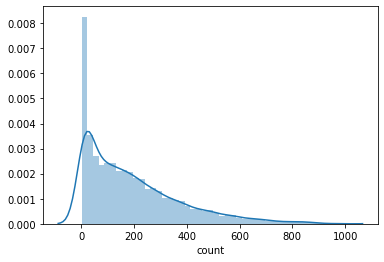

In [77]:
sns.distplot(train_data_feng['count'])

 log1p transformation

In [78]:
count_log = np.log1p(train_data_feng['count'])

In [79]:
np.log1p(train_data_feng['count']).skew()

-0.8514116321738531

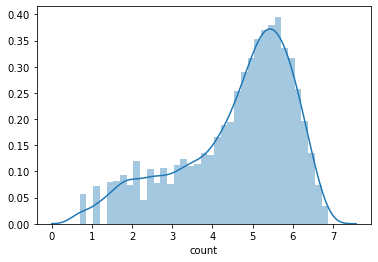

In [80]:
sns.distplot(np.log1p(train_data_feng['count']))

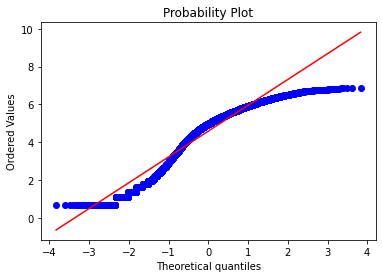

In [81]:
import pylab 
stats.probplot(count_log, dist="norm", plot=pylab)
pylab.show()

In [82]:
train_data_feng['count'] = np.log1p(train_data_feng['count'])


#### One-hot encoding categorical variable

In [83]:
# X, y matrix
X = train_data_feng.loc[:, train_data_feng.columns != 'count']
y = train_data_feng['count']

In [84]:
X = pd.get_dummies(X)

In [85]:
X.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'year',
       'month', 'hour', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'weather_Clear', 'weather_Cloudy',
       'weather_Heavy Rain', 'weather_Light Rain'],
      dtype='object')

#### Feature scaling

Standardization -> subtract mean value then divide by standard deviation

In [86]:
from sklearn.preprocessing import StandardScaler
std_sc = StandardScaler()
sf = std_sc.fit_transform(X.values) # feature scaled (return numpy array)
X_sc = pd.DataFrame(sf, index=X.index, columns=X.columns) # convert back to dataframe

## Machine Learning modeling

Models to evaluate - Linear Regression, Ridge, Lasso, SVM, Decision Tree, Random Forest, XGBoost

### Linear Regression 

In [87]:
# Defining Root Mean Squared Logarithmic Error (RMSLE)
 
def rmsle(y,y_pred):
    from sklearn.metrics import mean_squared_log_error
    msle = mean_squared_log_error(y,y_pred) # mean square log error (from sklearn)
    rmsle = np.sqrt(msle) # root mean square log error
    return rmsle 

In [88]:
from sklearn.linear_model import LinearRegression
LR_reg = LinearRegression()
LR_reg.fit(X_sc.values,y.values)
y_pred_LR = LR_reg.predict(X_sc) 

In [92]:
# Error with actual values instead of log values
rmsle(np.expm1(y),np.expm1(y_pred_LR))

1.0074171223272996

Not a good score

### Ridge Regression 

In [98]:
from sklearn.linear_model import  RidgeCV
ridge_cv = RidgeCV(alphas = [ 0.1, 0.5, 2, 5, 15, 30])
ridge_cv.fit(X_sc, y)
alpha = ridge_cv.alpha_
# Fine-tuning alpha in the viscinity of alpha
ridge_cv = RidgeCV(alphas = [alpha * 0.5, alpha * 1.5, alpha * 0.75, alpha * 1.25])
ridge_cv.fit(X_sc, y)
alpha = ridge_cv.alpha_
print("Best alpha :", alpha)
print ("Best Score:", ridge_cv.best_score_)

Best alpha : 22.5
Best Score: -1.0175339237689434


In [99]:
y_pred_Ridge = ridge_cv.predict(X_sc)

In [100]:
# Error with actual values instead of log values
rmsle(np.expm1(y),np.expm1(y_pred_Ridge))

1.007388437617929

No improvement

### Lasso Regression

In [101]:
from sklearn.linear_model import  LassoCV
lasso_cv = LassoCV(alphas = [ 0.001, 0.1, 0.5, 1, 3, 10])
lasso_cv.fit(X_sc, y)
alpha = lasso_cv.alpha_
# Fine-tuning alpha in the viscinity of alpha
lasso_cv = LassoCV(alphas = [alpha * 0.5, alpha * 1.5, alpha * 0.75])
lasso_cv.fit(X_sc, y)
alpha = lasso_cv.alpha_
print("Best alpha :", alpha)

Best alpha : 0.0015


In [102]:
y_pred_Lasso = lasso_cv.predict(X_sc)

In [103]:
# Error with actual values instead of log values
rmsle(np.expm1(y),np.expm1(y_pred_Lasso))

1.0074143737214887

Same

### Decision tree

In [105]:
from sklearn.tree import DecisionTreeRegressor
DT_reg = DecisionTreeRegressor(random_state=0)
DT_reg.fit(X_sc.values,y.values)
y_pred_DT = DT_reg.predict(X_sc)

In [113]:
rmsle(y,y_pred_DT)

0.005812779204262113

In [106]:
# Error with actual values instead of log values
rmsle(np.expm1(y),np.expm1(y_pred_DT))

0.01728233780567904

Looks like overfitting

In [110]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score;
score = cross_val_score(DT_reg, X = X_sc, y = y, scoring="neg_mean_squared_log_error", cv=10);
DT_rmsle_score = np.sqrt(-score);

In [112]:
print(DT_rmsle_score, DT_rmsle_score.mean())

[0.18809676 0.15577655 0.10165849 0.11409703 0.12348953 0.17713076
 0.13174373 0.09713426 0.09747417 0.13321423] 0.13198155028018152


In [116]:
# without log-transform
score = cross_val_score(DT_reg, X = X_sc, y = np.expm1(y), scoring="neg_mean_squared_log_error", cv=10);
DT_rmsle_score_il = np.sqrt(-score);
print(DT_rmsle_score_il, DT_rmsle_score_il.mean())

[0.61360158 0.65985503 0.40841389 0.46337367 0.55468626 0.63406456
 0.54886723 0.41015052 0.4416428  0.55848102] 0.5293136559998781


Much better than Linear Regression

### Random Forest

In [120]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
parameters = [{'n_estimators': [50, 100, 200, 300, 400],'max_features': ['auto', None, 'log2']}]
RF_reg = RandomForestRegressor(random_state=0)
grid_search_RF = GridSearchCV(estimator=RF_reg, 
                                    param_grid=parameters,
                                    scoring='neg_mean_squared_log_error', 
                                    cv = 10,
                                    n_jobs = -1,
                                    return_train_score=True)
grid_search_RF.fit(X_sc,y)
best_score = grid_search_RF.best_score_
best_parameters = grid_search_RF.best_params_

In [121]:
print("Best score:", np.sqrt(-best_score))
print("Best Parameters:", best_parameters)

Best score: 0.10189560991894157
Best Parameters: {'max_features': 'auto', 'n_estimators': 400}
